<a href="https://colab.research.google.com/github/jmohsbeck1/jpmc_mle/blob/machine_learning_bootcamp/Churn_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn ML model lab
# Machine learning bootcamp

In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

## Read the Dataset

In [2]:
url = "https://raw.githubusercontent.com/fenago/pythonml/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

In [3]:
df = pd.read_csv(url)

In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Transpose the Dataset to Make it Wide (not long)

In [6]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


## Data Types

In [7]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')

## Consider Empties...

In [9]:
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


In [10]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [11]:
df.TotalCharges = df.TotalCharges.fillna(0)

## Column Names and Naming Conventions

In [12]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

In [13]:
for col in string_columns:
 df[col] = df[col].str.lower().str.replace(' ', '_')

In [14]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                object
dtype: object

## Encode Churn Target Variable

In [15]:
df.churn = (df.churn == 'yes').astype(int)

Split the Data for Testing and Training

In [16]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

Train, Test, Validate

In [17]:
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

## Exploratory Data Analysis

In [18]:
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

## Validate the Distribution of the Target Variable

In [19]:
df_train_full.churn.value_counts()

0    4113
1    1521
Name: churn, dtype: int64

In [20]:
stopped = 1521/(4113 + 1521)
print("percentage of customers STOPPED using the services: ", round(stopped, 5))

percentage of customers STOPPED using the services:  0.26997


## Compute the MEAN of the Target Variable

In [21]:
global_mean = df_train_full.churn.mean()
round(global_mean, 3)


0.27

## We have an Imbalanced Dataset

# Categorical & Numerical Columns Require Different Treatments

## categorical:  which will contain the names of categorical variables
## numerical: will have the names of numerical variables

In [22]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
 'phoneservice', 'multiplelines', 'internetservice',
 'onlinesecurity', 'onlinebackup', 'deviceprotection',
 'techsupport', 'streamingtv', 'streamingmovies',
 'contract', 'paperlessbilling', 'paymentmethod']

numerical = ['tenure', 'monthlycharges', 'totalcharges']

# Categorical Data

In [23]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

# Numerical Data

## Get the Descriptive statistics for each column (Univariate Analysis)

In [24]:
df_train_full[numerical].describe()

,tenure,monthlycharges,totalcharges
count,5634.000000,5634.000000,5634.000000
mean,32.277955,64.779127,2277.423953
std,24.555211,30.104993,2266.412636
min,0.000000,18.250000,0.000000
25%,9.000000,35.400000,389.137500
50%,29.000000,70.375000,1391.000000
75%,55.000000,89.850000,3787.500000
max,72.000000,118.650000,8684.800000


# Correlations

In [25]:
df_train_full.corr()

<ipython-input-25-e1a2823212c6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train_full.corr()


,seniorcitizen,tenure,monthlycharges,totalcharges,churn
seniorcitizen,1.000000,0.023443,0.225234,0.110459,0.141966
tenure,0.023443,1.000000,0.251072,0.828268,-0.351885
monthlycharges,0.225234,0.251072,1.000000,0.650913,0.196805
totalcharges,0.110459,0.828268,0.650913,1.000000,-0.196353
churn,0.141966,-0.351885,0.196805,-0.196353,1.000000


# Feature Importance

## Feature Importance Based on Gender

In [26]:
female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()

male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()

## Feature Importance based on Partner

In [27]:
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
print('partner == yes:', round(partner_yes, 3))

partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()
print('partner == no:', round(partner_no, 3))

partner == yes: 0.205
partner == no: 0.33


## Risk Ratio

In [28]:
# risk = group rate / global_rate

# For “gender == female”, for example, the risk of churning is 1.02:
# risk = 27.7% / 27% = 1.02

## Compute Risk Ratio

In [29]:
global_mean = df_train_full.churn.mean()
print('global_mean: ', round(global_mean, 5))

df_group = df_train_full.groupby(by='gender').churn.agg(['mean'])

df_group['diff'] = df_group['mean'] - global_mean

df_group['risk'] = df_group['mean'] / global_mean

df_group


global_mean:  0.26997


,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


## Risk Ratio for ALL Categorical Variables

## Churn Analysis

## Mutual Information : Categorical

In [30]:
def calculate_mi(series):
 return mutual_info_score(series, df_train_full.churn)

In [31]:
df_mi = df_train_full[categorical].apply(calculate_mi)

df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


# Correlation Coefficient

In [32]:
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

# Feature Engineering

## Transform all categorical variables to numeric forms

## One Hot Encoding

## DictVectorizer

In [33]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

## Dictionary Vectorizer

In [34]:
dv = DictVectorizer(sparse=False)

dv.fit(train_dict)

X_train = dv.transform(train_dict)

## Peek at the Vectorized Data

In [35]:
X_train[0]

dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

# Machine learning

## Predictive Analytics from the clean Telco Dataset

## ML for Classification


## Linear Regression from Scratch in Python

In [36]:
def linear_regression(xi):
  result = bias
  for j in range(n):
    result = result + xi[j] * w[j]
  return result

## Logistic Regression from Scratch using Python

In [37]:
def logistic_regression(xi):
  score = bias
  for j in range(n):
    score = score + xi[j] * w[j]
    prob = sigmoid(score)
  return prob

def sigmoid(score):
  return 1 / (1 + math.exp(-score))

## Training the Logistic Regression Model

In [38]:
model = LogisticRegression(solver='liblinear', random_state=1)

model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

## One Hot Encoding

In [39]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')

X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)

In [40]:
y_pred = model.predict_proba(X_val)[:, 1]

y_pred >= 0.5

array([False, False, False, ..., False,  True, False])

## Introducing Accuracy

In [41]:
churn = y_pred >= 0.5

(y_val == churn).mean() #Quality Measure called ACCURACY

0.8016129032258065

In [42]:
print(y_val)

print(churn)



[0 1 0 ... 0 0 0]
[False False False ... False  True False]


## Model Interpretation

## Coefficients

In [43]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.563,
 'contract=one_year': -0.086,
 'contract=two_year': -0.599,
 'dependents=no': -0.03,
 'dependents=yes': -0.092,
 'deviceprotection=no': 0.1,
 'deviceprotection=no_internet_service': -0.116,
 'deviceprotection=yes': -0.106,
 'gender=female': -0.027,
 'gender=male': -0.095,
 'internetservice=dsl': -0.323,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.116,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.168,
 'multiplelines=no_phone_service': 0.127,
 'multiplelines=yes': -0.081,
 'onlinebackup=no': 0.136,
 'onlinebackup=no_internet_service': -0.116,
 'onlinebackup=yes': -0.142,
 'onlinesecurity=no': 0.258,
 'onlinesecurity=no_internet_service': -0.116,
 'onlinesecurity=yes': -0.264,
 'paperlessbilling=no': -0.213,
 'paperlessbilling=yes': 0.091,
 'partner=no': -0.048,
 'partner=yes': -0.074,
 'paymentmethod=bank_transfer_(automatic)': -0.027,
 'paymentmethod=credit_card_(automatic)': -0.136,
 'paymentmethod=electronic_check': 0.175,


## Prepare a Small Subset to Break Down the Categoricals

In [44]:
small_subset = ['contract', 'tenure', 'totalcharges']

train_dict_small = df_train[small_subset].to_dict(orient='records')

dv_small = DictVectorizer(sparse=False)

dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'tenure', 'totalcharges'], dtype=object)

## Train the Small Subset

In [45]:
model_small = LogisticRegression(solver='liblinear', random_state=1)

model_small.fit(X_small_train, y_train)

model_small.intercept_[0] #Check the bias

dict(zip(dv_small.get_feature_names_out(), model_small.coef_[0].round(3))) #Check the other weights

{'contract=month-to-month': 0.91,
 'contract=one_year': -0.144,
 'contract=two_year': -1.404,
 'tenure': -0.097,
 'totalcharges': 0.001}

## Let’s also check its accuracy

## For that, we first make predictions on the validation dataset and then compute the accuracy score:


In [46]:
val_dict_small = df_val[small_subset].to_dict(orient='rows')

X_small_val = dv_small.transform(val_dict_small)
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

churn_small = y_pred_small >= 0.5
accuracy_score(y_val, churn_small)

<ipython-input-46-af3b63365be3>:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  val_dict_small = df_val[small_subset].to_dict(orient='rows')


0.7672043010752688

## Understanding The Importance of Categories

In [47]:
dict(zip(dv_small.get_feature_names_out(), model_small.coef_[0].round(3)))

{'contract=month-to-month': 0.91,
 'contract=one_year': -0.144,
 'contract=two_year': -1.404,
 'tenure': -0.097,
 'totalcharges': 0.001}

## Using the Churn Model

In [48]:
customer = {
 'customerid': '8879-zkjof',
 'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'no',
 'dependents': 'no',
 'tenure': 41,
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'dsl',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'one_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'bank_transfer_(automatic)',
 'monthlycharges': 79.85,
 'totalcharges': 3320.75,
}


# Vectorized Input

In [49]:
X_test = dv.transform([customer])

print(X_test)

[[0.00000e+00 1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  0.00000e+00 7.98500e+01 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  1.00000e+00 1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 4.10000e+01 3.32075e+03]]


## Put the Matrix into the Trained Model

In [50]:
model.predict_proba(X_test)

array([[0.92667889, 0.07332111]])

In [51]:
model.predict_proba(X_test)[0, 1]

0.07332111084949638

## Take a look at another customer

In [52]:
customer = {
 'gender': 'female',
 'seniorcitizen': 1,
 'partner': 'no',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'no',
'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'no',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 1,
 'monthlycharges': 85.7,
 'totalcharges': 85.7
}

## Let’s Make a Prediction

In [53]:
X_test = dv.transform([customer])

model.predict_proba(X_test)[0, 1]

0.8321656556055403

# Parameter tuning

## K-fold cross-validation

In [54]:
def train(df, y):
  cat = df[categorical + numerical].to_dict(orient='rows')

  dv = DictVectorizer(sparse=False)
  dv.fit(cat)

  X = dv.transform(cat)

  model = LogisticRegression(solver='liblinear')
  model.fit(X, y)

  return dv, model

In [55]:
def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='rows')
    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred


In [56]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

aucs = []

In [57]:
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)


<ipython-input-54-8a78b19d212a>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-54-8a78b19d212a>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is

In [58]:
print(aucs)

[0.8493392490816277, 0.8413366336633662, 0.8590269587894291, 0.8330260883877869, 0.8242555831265509, 0.8416250416250417, 0.8437154021491371, 0.8223355471220746, 0.8450570623981029, 0.8611811367685119]


In [59]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


## Finding best parameters

## We first adjust the train function to take in an additional parameter

In [60]:
def train_best(df, y, C):
  cat = df[categorical + numerical].to_dict(orient='rows')

  dv = DictVectorizer(sparse=False)
  dv.fit(cat)

  X = dv.transform(cat)

  model = LogisticRegression(solver='liblinear', C=C)
  model.fit(X, y)

  return dv, model



In [61]:
nfolds = 5
kfold_best = KFold(n_splits=nfolds, shuffle=True, random_state=1)

In [62]:
for C in [ 0.001, 0.01, 0.1, 0.5, 10 ]:
  aucs = []

  for train_idx, val_idx in kfold_best.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train_best(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

  print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))



<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is

C=0.001, auc = 0.825 ± 0.013


<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is

C=0.01, auc = 0.839 ± 0.009


<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is

C=0.1, auc = 0.841 ± 0.008


<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is

C=0.5, auc = 0.841 ± 0.007


<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')
<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is

C=10, auc = 0.841 ± 0.007


<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')


## Let’s use our train and predict functions for that:

In [63]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train_best(df_train_full, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)


<ipython-input-60-b726a9cd3ee0>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')


auc = 0.858


<ipython-input-55-3297b48b7669>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  cat = df[categorical + numerical].to_dict(orient='rows')


## ROC Curve

## We simply can use the roc_curve function from the metrics package Scikit-Learn:

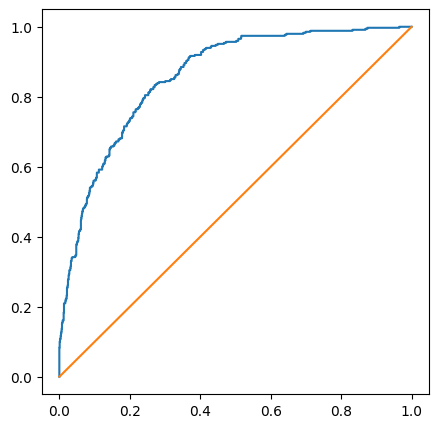

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
